# Identify Fraud from Enron Email

## 1 Introduction

In this report, I will use machine learning to build a person of interest (POI) identifier based on Enron financial and email data made public as a result of the Enron scandal.

I will start by exploring the data set and investigating outliers. Then I will build the POI identifier following the process of feature selection/engineering, algorithm picking/tuning, validation, evaluation.

In [11]:
import pickle
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
# Change figure size into 8 by 6 inches
matplotlib.rcParams['figure.figsize'] = (8, 6)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


## 2 Data Exploration

Q: Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. Important characteristics include:
- total number of data points
- allocation across classes (POI/non-POI)
- number of features
- are there features with many missing values? etc.

A: There are 146 data points in the dataset.

Out of the 146 data points, there are 18 of them are identified as POIs, and the rest 128 are non-POIs.

Each data point consists the name of the person and 21 features (1 POI flag, 14 financial features and 6 email features). All financial features have real number values, and all email features except email_address feature (string value) have integer values.

All features have missing values (tabulated below). I notice there is a large difference in terms of percentages of missing values between POIs and non_POIs. By imputing the missing values with 0, I get to preserve this distinction. In other words, after imputing, a value of 0 gives different probability of being a POI than being a non-POI.

In [2]:
# Load the dataset
with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [26]:
# Total number of data points
print('There are {} people in the dataset.'.format(len(data_dict)))

There are 146 people in the dataset.


In [27]:
# Allocation across classes (POI/non-POI)
poi_counts = defaultdict(int)
for features_values in data_dict.values():
    poi_counts[features_values['poi']] += 1
print('There are {} POIs and {} non-POIs.'.format(poi_counts[True], poi_counts[False]))

There are 18 POIs and 128 non-POIs.


In [28]:
# Number of features
print('There are {} features.'.format(len(list(data_dict.values())[0])))
# Names of features
list(list(data_dict.values())[0].keys())

There are 21 features.


['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']

In [38]:
# Features with missing values
nan_counts_poi = defaultdict(int)
nan_counts_non_poi = defaultdict(int)
for data_point in data_dict.values():
    if data_point['poi'] == True:
        for feature, value in data_point.items():
            if value == "NaN":
                nan_counts_poi[feature] += 1
    elif data_point['poi'] == False:
        for feature, value in data_point.items():
            if value == "NaN":
                nan_counts_non_poi[feature] += 1
    else:
        print('Got an uncategorized person.')
nan_counts_df = pd.DataFrame([nan_counts_poi, nan_counts_non_poi]).T
nan_counts_df = nan_counts_df.fillna(value=0)
nan_counts_df.columns = ['# NaN in POIs', '# NaN in non-POIs']
nan_counts_df['# NaN total'] = nan_counts_df['# NaN in POIs'] + \
                               nan_counts_df['# NaN in non-POIs']
nan_counts_df['% NaN in POIs'] = nan_counts_df['# NaN in POIs'] / \
                                          poi_counts[True] * 100
nan_counts_df['% NaN in non-POIs'] = nan_counts_df['# NaN in non-POIs'] / \
                                          poi_counts[False] * 100
nan_counts_df['% NaN total'] = nan_counts_df['# NaN total'] / \
                                          len(data_dict) * 100
    
nan_counts_df

,# NaN in POIs,# NaN in non-POIs,# NaN total,% NaN in POIs,% NaN in non-POIs,% NaN total
bonus,2.0,62.0,64.0,11.111111,48.43750,43.835616
deferral_payments,13.0,94.0,107.0,72.222222,73.43750,73.287671
deferred_income,7.0,90.0,97.0,38.888889,70.31250,66.438356
director_fees,18.0,111.0,129.0,100.000000,86.71875,88.356164
email_address,0.0,35.0,35.0,0.000000,27.34375,23.972603
exercised_stock_options,6.0,38.0,44.0,33.333333,29.68750,30.136986
expenses,0.0,51.0,51.0,0.000000,39.84375,34.931507
from_messages,4.0,56.0,60.0,22.222222,43.75000,41.095890
from_poi_to_this_person,4.0,56.0,60.0,22.222222,43.75000,41.095890
from_this_person_to_poi,4.0,56.0,60.0,22.222222,43.75000,41.095890


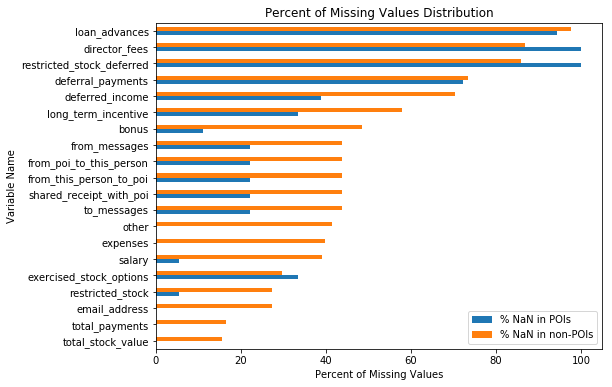

In [54]:
# Plot missing values distribution
ax = nan_counts_df.sort_values('# NaN total')[['% NaN in POIs', '% NaN in non-POIs']].plot(kind='barh', 
                                                                                    stacked=False)
ax.set_title('Percent of Missing Values Distribution')
ax.set_xlabel('Percent of Missing Values')
ax.set_ylabel('Variable Name')

## 3 Outlier Investigation

Q: Student response identifies outlier(s) in the financial data, and explains how they are removed or otherwise handled. Outliers are removed or retained as appropriate.

A: By examing the financial features, I found out two kinds of outliers.

The first kind is a data point with name 'TOTAL', and it is probably because when the dataset was generated from some spreadsheet, the summary row corresponding to the sum was also included. I removed this 'TOTAL' data point from my analysis. 

The other outliers consist of people with extreme large values of financial features. Since these values are accurate and some of them are acutally POIs, I retained these data points.

In [3]:
def allFeaturesFormat(data_dict):
    '''Convert the data dictionary with all features to a pandas DataFrame.
    
    'NaN' is filled with 0.
    
    Arg:
    data_dict: A dictionry containing all features for the enron data
    
    return:
    df: A pandas DataFrame
    '''
    temp_list = []
    for name, features_values in data_dict.items():
        temp_dict = {}
        temp_dict['name'] = name
        for feature, value in features_values.items():
            if feature in ['poi', 'email_address']:
                temp_dict[feature] = value
            else:
                if value == 'NaN':
                    value = 0
                temp_dict[feature] = float(value)
        temp_list.append(temp_dict)
    df = pd.DataFrame(temp_list)
    return df

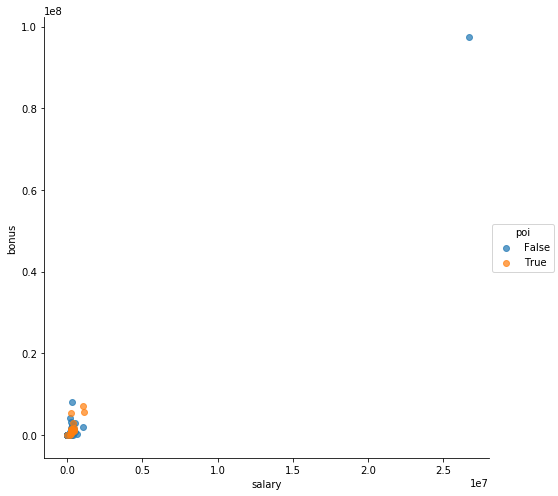

In [4]:
df = allFeaturesFormat(data_dict)
g = sns.FacetGrid(df, hue='poi', size=7)
g.map(plt.scatter, 'salary', 'bonus', alpha=.7)
g.add_legend()

In [5]:
# Remove the outlier "total"
data_dict.pop('TOTAL', 0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

## 4 Create New Features Part I

Q: At least one new feature is implemented. Justification for that feature is provided in the written response, and the effect of that feature on the final algorithm performance is tested.

A: Three new features are created:

The features **fraction_from_poi** and **fraction_to_poi** are the fractions of messages the persion receives from/sends to a POI. These two features measure the degree of how the persion is connected to POIs, and someone who is more connected with POIs, this person should have a higher probablity being a POI him/herself.

The feature **payments_stock_total** measures the sum of total payments and stock values. A POI should have a higher payments_stock_total comparing to a non-POI in general.

Out of the 3 new features, fraction_to_poi are the highest scored feature of the final AdaBoost based model with 7 features selected by decision tree method. The effect of this new feature on the final algorithm is tested at Create New Features Part 2 near the end of the report.

In [6]:
def computeFraction(poi_messages, all_messages):
    '''Calculate the fraction of one person's messages to/from POIs.
    
    Arg:
    poi_messages: Number of messages to/from POIs
    all_messages: Total number of messages send/receive
    
    Return:
    fraction: The fraction of messages to/from that person that are from/to POIs
    
    '''
    fraction = 0
    if poi_messages != "NaN" and all_messages != "NaN":
        fraction = poi_messages / all_messages
    return fraction

def computeTotal(total_payments, total_stock_value):
    '''Calculate the sum of total payments and total stock value
    
    Arg:
    total_payments: Total payments of a given person
    total_stock_value: Total stock value of a given person
    
    Return:
    total: The sum of these two values
    '''
    if total_payments == "NaN":
        total_payments = 0
    if total_stock_value == "NaN":
        total_stock_value = 0
    total = total_payments + total_stock_value
    return total

for data_point in data_dict.values():    
    # Create feature fraction_from_poi
    from_poi_to_this_person = data_point['from_poi_to_this_person']
    to_messages = data_point['to_messages']
    fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
    data_point['fraction_from_poi'] = fraction_from_poi

    # Create feature fraction_to_poi
    from_this_person_to_poi = data_point['from_this_person_to_poi']
    from_messages = data_point['from_messages']
    fraction_to_poi = computeFraction(from_this_person_to_poi, from_messages)
    data_point['fraction_to_poi'] = fraction_to_poi
    
    # Create feature payments_stock_total
    total_payments = data_point['total_payments']
    total_stock_value = data_point['total_stock_value']
    data_point['payments_stock_total'] = computeTotal(total_payments, total_stock_value)

In [7]:
# Prepare features and labels for machine learning

df = allFeaturesFormat(data_dict)
# Subset dataframe with only numeric columns as features
features = df.drop(['poi', 'name', 'email_address'], axis=1)
# Labels are the 'poi' column
labels = df.poi

## 5 Validation Strategy

Q: Response addresses what validation is and why it is important.

Performance of the final algorithm selected is assessed by splitting the data into training and testing sets or through the use of cross validation, noting the specific type of validation performed.

A: Validation is the process of giving estimate of model performance on a dataset independent of training dataset. Validation can serve as a check on overfitting, and it also can help assess how well the trained model will generalize for unseen datasets.

In [8]:
# First Attempt Split #

# Split the whole dataset into stratified training/validation and test sets
# Training/validation set is used for building the model
# Test set is reserved for final model assessment

# Step 1:
# Split the whole dataset into training/validation set and test set
# features_train_validation, features_test, labels_train_validation, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
    
# Step 2: 
# Split the training/validation set further into training set and validation set using StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1000, test_size=0.3, random_state=42)

After buidling and tuning the model on my training/validation set, I assess my model performance on my reserved test set. Due to the limited amount of data in the dataset and the imbalance of number of POIs versus non-POIs, my test set ends up with only about 5 POIs. And depending on which few POIs are assigned to test set, the evaluation metrics scores vary a lot.

For obtaining more stable evaluation metrics scores from this imbalanced small dataset, I use StratifiedShuffleSplit to random split the whole dataset, and use the whole dataset for both buidling the model and assessing the model. I understand by doing this the metrics scores I obtain will be over optimistic as the model have actually seen the test set during training.

In [14]:
# Second Attempt Split #
# Split the whole data set into two sets
# They will be used as training set and validation set during model selection
# They will be used as training set and test set during model evaluation
sss = StratifiedShuffleSplit(n_splits=1000, test_size=0.3, random_state=42)